In [3]:
import numpy as np
from math import sqrt
from pprint import pprint
from sklearn import datasets
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer                 # para crear metricas propias a mano
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [4]:
# Cargar y explorar los datos
datos = datasets.load_diabetes()
# print(datos)
print(np.shape(datos.data))

(442, 10)


In [5]:
# Extraer la matriz de datos "X" y la variable target "y"
X = datos.data
y = datos.target

In [6]:
# Partición EXTERNA: hold-out split 80% train - 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Estandarización de los datos de entrenamiento y test
standarizer = preprocessing.StandardScaler()

X_train = standarizer.fit_transform(X_train)
X_test = standarizer.transform(X_test)

In [8]:
# Métricas de evaluación.
metricas = {
  'MAE': 'neg_mean_absolute_error',
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False),
  'R2': 'r2'}

In [9]:
# Definimos un algoritmo SVM de regresión
regresor = SVR(C= 100, gamma= 'auto', kernel= 'rbf')

In [10]:
# Validación y evaluación del modelo.
# en "cv = KFold(n_splits=5)" se hace un cross-validation INTERNO!! 
results = cross_validate(regresor, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring = metricas)

In [11]:
# Presentación de los resultados de la evaluación.
# print(results)

for metric, array in results.items():
    print(f'Para la métrica \t{metric},\t obtiene una puntuación promedio \t {round(array.mean(),2)}')

Para la métrica 	fit_time,	 obtiene una puntuación promedio 	 0.01
Para la métrica 	score_time,	 obtiene una puntuación promedio 	 0.0
Para la métrica 	test_MAE,	 obtiene una puntuación promedio 	 -47.08
Para la métrica 	test_RMSE,	 obtiene una puntuación promedio 	 -59.36
Para la métrica 	test_MAPE,	 obtiene una puntuación promedio 	 -39.74
Para la métrica 	test_R2,	 obtiene una puntuación promedio 	 0.4


In [12]:
# Una vez hemos optimizado los hiperparámetros en el conjunto de validación, entrenamos un nuevo modelo que contenga
# todos los datos de entrenamiento (es decir, train + validation) para evaluar el test
model = SVR(C=10, gamma='scale', kernel='rbf')
model = model.fit(X_train, y_train)

In [13]:
# Extraemos el error absoluto promedio (MAE) del conjunto de test
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test results (MAE): ', mae)
print('Test results (r2): ', r2) # correlacion lineal

Test results (MAE):  41.319671295107455
Test results (r2):  0.4937125101265256


In [14]:
# También podemos extraer las predicciones para cuánto difieren los valores predichos de los reales
print('Predicciones:   ', np.round(y_pred[:10], 1))
print('Valores reales: ', y_test[:10])

Predicciones:    [149.  172.2 152.9 212.3 110.1 122.3 227.3 191.8 106.7 103.9]
Valores reales:  [219.  70. 202. 230. 111.  84. 242. 272.  94.  96.]


In [15]:
# Grafica de realidad -vs- prediccion.
def grafica_real_vs_pred(y_true, y_pred, metricas, algoritmo):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.show()

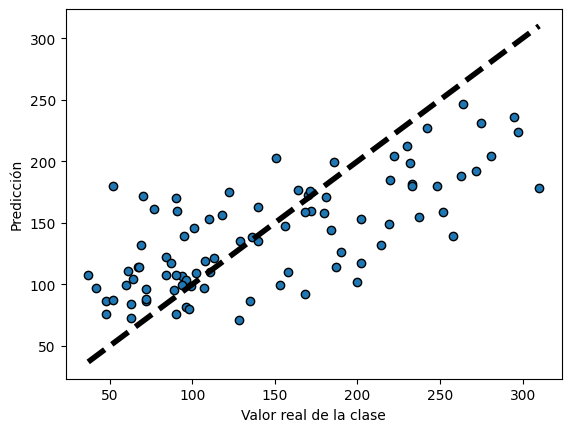

In [16]:
grafica_real_vs_pred(y_test, y_pred, metricas, model)

In [17]:
from sklearn.model_selection import GridSearchCV

In [23]:
# hiperparametros
h_params = {'C': [0.01, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']}

# Métricas de evaluación.
metricas = ['r2', 'neg_root_mean_squared_error']

In [24]:
GD = GridSearchCV(estimator= SVR(),
                  param_grid= h_params,
                  scoring= metricas, 
                  cv= KFold(n_splits=5, shuffle= True, random_state= 42),
                  n_jobs= -1,
                  refit='r2')

In [25]:
GD.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 1, 10, 100], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'rbf']},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [26]:
GD.best_estimator_

SVR(C=1, gamma='auto', kernel='linear')

In [28]:
GD.best_score_

0.47492607147800314

In [29]:
import pandas as pd

In [30]:
results_frame = pd.DataFrame(GD.cv_results_)

display(results_frame.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_r2,split1_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.006447,0.000926,0.002992,0.000631,0.01,auto,linear,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}",-0.152018,0.064059,...,0.082944,13,-78.699201,-80.685729,-67.477337,-73.559481,-82.640443,-76.612438,5.478207,13
1,0.008724,0.000565,0.006982,0.001263,0.01,auto,rbf,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",-0.222757,-0.000299,...,0.083953,15,-81.079436,-83.413715,-69.946998,-76.275850,-85.494093,-79.242018,5.568898,15
2,0.006745,0.002079,0.002908,0.000938,0.01,scale,linear,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",-0.152018,0.064059,...,0.082944,13,-78.699201,-80.685729,-67.477337,-73.559481,-82.640443,-76.612438,5.478207,13
3,0.009045,0.000876,0.006584,0.000800,0.01,scale,rbf,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",-0.222789,-0.000288,...,0.083969,16,-81.080525,-83.413253,-69.946571,-76.275609,-85.494787,-79.242149,5.569225,16
4,0.009373,0.002515,0.002950,0.000037,1,auto,linear,"{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}",0.427009,0.519917,...,0.041141,1,-55.502745,-57.787073,-52.482180,-54.034573,-58.599201,-55.681155,2.277120,1
